In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import bempp.api
from bempp.api import shapes
import bempp_cavity

# Define Mesh

In [3]:
ELEMENT_SIZE = 0.5
LENGTH_CAVITY = 1
LENGTH_WALL = 3

In [4]:
inner_walls = [
    shapes.cube(
        length=1, h=ELEMENT_SIZE,
        origin=(-1.25, -1/2, -1.25)
    ),
    shapes.cube(
        length=1, h=ELEMENT_SIZE,
        origin=(0.25, -1/2, -1.25)
    ),
    shapes.cube(
        length=1, h=ELEMENT_SIZE,
        origin=(-1.25, -1/2, 0.25)
    ),
    shapes.cube(
        length=1, h=ELEMENT_SIZE,
        origin=(0.25, -1/2, 0.25)
    ), 
]
outer_wall = shapes.cube(
        length=LENGTH_WALL, h=ELEMENT_SIZE,
        origin=(-LENGTH_WALL/2, -LENGTH_WALL/2, -LENGTH_WALL/2)
)
grid = bempp_cavity.create_grid(outer_wall, *inner_walls)

# Define Parameters and incident wave

In [5]:
Ks = [1, 1, 1, 1, 1, 1]
MUs = [1, 1, 1, 1, 1, 1]
wave = bempp_cavity.IncidentWave(Ks[0], MUs[0])

1 1


In [6]:
parameters = bempp_cavity.Parameters(
    nearfield_cutoff=1.0,
    ACA=0.1,
    quadrature=(1, 1, 1, 1)
)

# Create Models and Solve Them

In [7]:
residuals_sf = {}
residuals_wf = {}
info_sf = {}
info_wf = {}

In [8]:
methods = [
    'self',
    'diagonal',
    'none', 
]

In [9]:
for method in methods:
    print(method)
    model = bempp_cavity.Model(grid, Ks, MUs, wave)
    sol = model.solve(preconditioner=method)
    residuals_sf[method] = sol.residuals
    info_sf[method] = sol.info
    del sol
    del model

self
diagonal
none


In [13]:
for method in methods:
    print(method)
    model = bempp_cavity.Model(grid, Ks, MUs, wave, spaces='RWG-dominant')
    sol = model.solve(preconditioner=method, preconditioner_parameters=parameters.get())
    residuals_wf[method] = sol.residuals
    info_wf[method] = sol.info
    del sol
    del model

self
diagonal
none


# Analyse Results

## Convergence

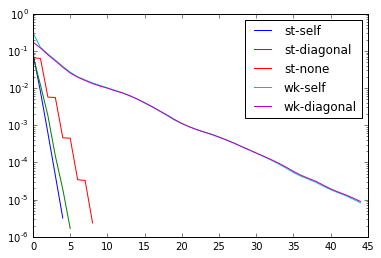

In [15]:
for method in methods:
    if method in residuals_sf:
        plt.semilogy(residuals_sf[method], label='st-'+method)
for method in residuals_wf:
    if method in residuals_wf and method is not 'none':
        plt.semilogy(residuals_wf[method], label='wk-'+method)
plt.legend()
plt.show();

## Runtime

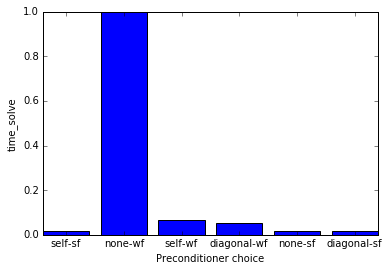

In [26]:
#
# Plot bar chart of run times
#
def plot_metric(metric, info_sf, info_wf):
    sol = {}
    for k, v in info_sf.items():
        sol[k+'-sf'] = v
    for k, v in info_wf.items():
        sol[k+'-wf'] = v
    ref = sol['none-wf'][metric]
    x = [i for i, _ in enumerate(sol.keys())]
    times = [sol[method][metric]/ref for method in sol.keys()]
    xlabels = list(sol.keys())

    fig, ax = plt.subplots(1, 1)
    plt.setp(ax, xticks=x, xticklabels=xlabels)


    ax.bar(x, times, align='center');
    ax.set_xlabel('Preconditioner choice')
    ax.set_ylabel(metric)
    pass

plot_metric('time_solve', info_sf, info_wf)

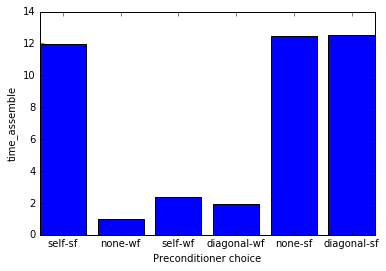

In [27]:
plot_metric('time_assemble', info_sf, info_wf)

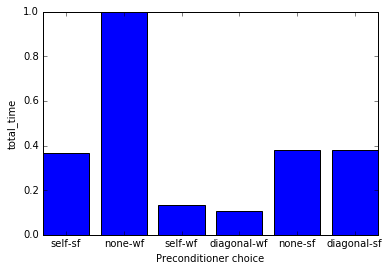

In [32]:
for method in methods:
    for d in [info_sf, info_wf]:
        d[method]['total_time'] = d[method]['time_solve'] + d[method]['time_assemble']
plot_metric('total_time', info_sf, info_wf)

# Sanity Check

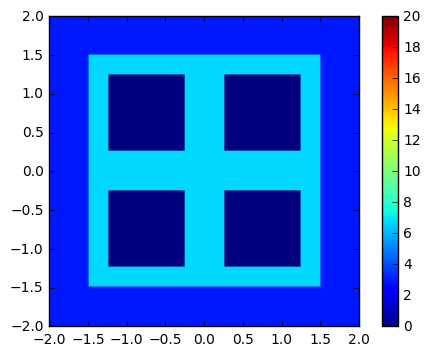

In [15]:
sol_sf.show_domains()

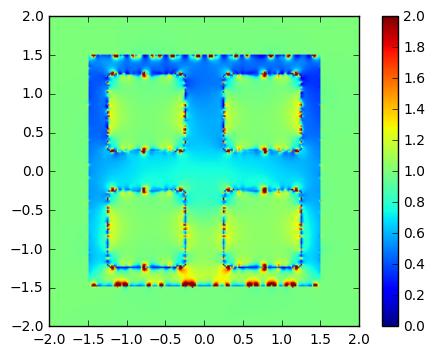

In [83]:
sol_sf['none'].plot()

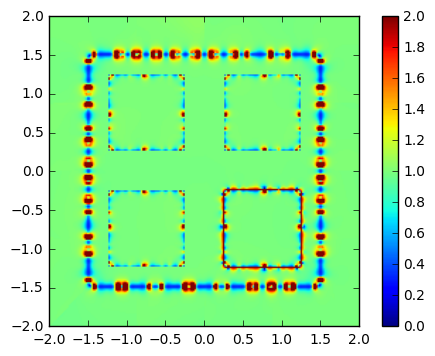

In [13]:
sol_wf['diagonal'].plot()

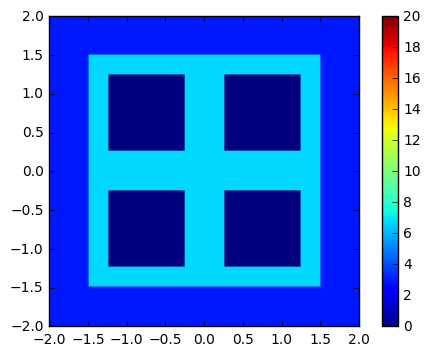

In [63]:
sol_wf['none'].show_domains()

In [65]:
sol_wf['none']._traces is None

True